In [1]:
!pip install torchinfo

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from PIL import Image
import PIL

from pathlib import Path
import os
import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
# фиксация SEED
SEED = 42
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Подключение Google-диска для сохранения весов
from google.colab import drive
drive.mount('/content/drive/')

ROOT_DIR = Path('/content/')
DATA_DIR = Path('/content/drive/MyDrive/NST_Bot')
Caltech101_FILE = Path('101_ObjectCategories.tar')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Current device = {device}")

!nvidia-smi

Mounted at /content/drive/
CUDA is available!  Training on GPU ...
Current device = cuda
Mon Jan 10 06:40:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+

In [4]:
# http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html
gdd.download_file_from_google_drive(file_id='1JyQaOt_7OZssRq4CnOQSsuEBOlP4e6bQ',
                                    dest_path = ROOT_DIR / Caltech101_FILE, unzip=False)
!tar -xf ./101_ObjectCategories.tar
!rm -rf /content/101_ObjectCategories/BACKGROUND_Google

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

def image_converter(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [7]:
class ImageDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        # LabelEncoding
        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        # загружаем изображение, ресайз до нужного размера длинной стороны,
        # к короткой стороне изображения добавляем паддинг
        image = Image.open(file).convert('RGB')
        image.load()
        image = PIL.ImageOps.pad(image, (RESCALE_SIZE, RESCALE_SIZE))
        return image
  
    def __getitem__(self, index):
        # Преобразование изображений в тензоры PyTorch, нормализации входа
        # и 3 аугментации для train данных
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomRotation(degrees=5),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

In [8]:
MAIN_DIR = Path('/content/101_ObjectCategories')
RESCALE_SIZE = 224

all_files = list(MAIN_DIR.rglob('*.jpg'))
all_labels = [path.parent.name for path in all_files]

train_files, val_files = train_test_split(all_files, test_size=0.2, \
                                          stratify=all_labels)

train_dataset = ImageDataset(train_files, mode='train')
val_dataset = ImageDataset(val_files, mode='val')

# Количество классов в данных
n_classes = len(np.unique(all_labels))
print(f'Количество классов в датасете Caltech101 = {n_classes}')

print(f'{len(all_files)} => {len(train_files)} & {len(val_files)}')

Количество классов в датасете Caltech101 = 101
8677 => 6941 & 1736


In [9]:
"""
Балансировка данных
"""
def create_dct(files, labels):
    # Формируем словарь с количеством картинок для каждого класса
    dct_images = {}
    for label in np.unique(all_labels).tolist():
        dct_images[label] = []

    for path, label in zip(files, labels):
        dct_images[label].append(path)

    return dct_images

dct_label_paths = create_dct(train_dataset.files, train_dataset.labels)

# Если картинок меньше 100, то размножаем пути для класса
min_number = 100
for label in dct_label_paths:
    if len(dct_label_paths[label]) < min_number:
        dct_label_paths[label] = dct_label_paths[label] * (min_number // len(dct_label_paths[label]))
        dct_label_paths[label].extend(dct_label_paths[label][:min_number - len(dct_label_paths[label])])
    
new_train_files = []

for label in dct_label_paths:
    new_train_files.extend(dct_label_paths[label])

train_dataset = ImageDataset(new_train_files, mode='train')
print(f"{len(train_files)} => {len(new_train_files)}")

6941 => 11827


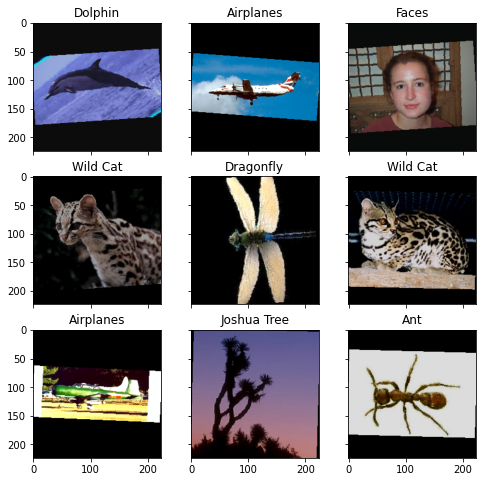

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(train_dataset)))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), img_label, plt_ax=fig_x)

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    opt = torch.optim.AdamW(model.parameters(),lr=1e-4, betas=(0.5, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)

        history.append((train_loss, train_acc, val_loss, val_acc))
        
        print(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        scheduler.step()

    return history

In [13]:
# Load VGG19 Skeleton and Weights
vgg19 = models.vgg19(pretrained = True, progress = True)
vgg19.classifier[-1] = nn.Linear(4096, n_classes)
vgg19 = vgg19.to(device)
summary(vgg19, (64, 3, 128, 128)) # B,C,H,W

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [64, 512, 4, 4]           --
│    └─Conv2d: 2-1                       [64, 64, 128, 128]        1,792
│    └─ReLU: 2-2                         [64, 64, 128, 128]        --
│    └─Conv2d: 2-3                       [64, 64, 128, 128]        36,928
│    └─ReLU: 2-4                         [64, 64, 128, 128]        --
│    └─MaxPool2d: 2-5                    [64, 64, 64, 64]          --
│    └─Conv2d: 2-6                       [64, 128, 64, 64]         73,856
│    └─ReLU: 2-7                         [64, 128, 64, 64]         --
│    └─Conv2d: 2-8                       [64, 128, 64, 64]         147,584
│    └─ReLU: 2-9                         [64, 128, 64, 64]         --
│    └─MaxPool2d: 2-10                   [64, 128, 32, 32]         --
│    └─Conv2d: 2-11                      [64, 256, 32, 32]         29

In [14]:
history = train(train_dataset, val_dataset, vgg19, epochs=50, batch_size=64)

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.0995     val_loss 0.3608 train_acc 0.7342 val_acc 0.9078


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.2462     val_loss 0.2299 train_acc 0.9290 val_acc 0.9320


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.1125     val_loss 0.2221 train_acc 0.9667 val_acc 0.9401


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.0936     val_loss 0.2369 train_acc 0.9751 val_acc 0.9510


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.0424     val_loss 0.2387 train_acc 0.9877 val_acc 0.9447


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.0346     val_loss 0.2209 train_acc 0.9900 val_acc 0.9545


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.0242     val_loss 0.2124 train_acc 0.9935 val_acc 0.9510


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.0237     val_loss 0.2250 train_acc 0.9937 val_acc 0.9430


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.0188     val_loss 0.1828 train_acc 0.9951 val_acc 0.9608


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.0111     val_loss 0.1965 train_acc 0.9965 val_acc 0.9551


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 011 train_loss: 0.0038     val_loss 0.2270 train_acc 0.9989 val_acc 0.9562


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 012 train_loss: 0.0042     val_loss 0.2893 train_acc 0.9988 val_acc 0.9482


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 013 train_loss: 0.0049     val_loss 0.2242 train_acc 0.9987 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 014 train_loss: 0.0082     val_loss 0.2197 train_acc 0.9984 val_acc 0.9556


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 015 train_loss: 0.0033     val_loss 0.2223 train_acc 0.9991 val_acc 0.9597


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 016 train_loss: 0.0081     val_loss 0.2175 train_acc 0.9984 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 017 train_loss: 0.0011     val_loss 0.2217 train_acc 0.9997 val_acc 0.9556


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 018 train_loss: 0.0017     val_loss 0.2415 train_acc 0.9996 val_acc 0.9539


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 019 train_loss: 0.0017     val_loss 0.2625 train_acc 0.9995 val_acc 0.9539


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 020 train_loss: 0.0021     val_loss 0.2188 train_acc 0.9996 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 021 train_loss: 0.0024     val_loss 0.2415 train_acc 0.9992 val_acc 0.9562


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 022 train_loss: 0.0017     val_loss 0.2403 train_acc 0.9995 val_acc 0.9528


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 023 train_loss: 0.0012     val_loss 0.2322 train_acc 0.9997 val_acc 0.9574


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 024 train_loss: 0.0006     val_loss 0.2411 train_acc 0.9997 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 025 train_loss: 0.0035     val_loss 0.2170 train_acc 0.9991 val_acc 0.9533


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 026 train_loss: 0.0013     val_loss 0.2289 train_acc 0.9995 val_acc 0.9591


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 027 train_loss: 0.0010     val_loss 0.2271 train_acc 0.9998 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 028 train_loss: 0.0010     val_loss 0.2301 train_acc 0.9997 val_acc 0.9568


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 029 train_loss: 0.0007     val_loss 0.2365 train_acc 0.9997 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 030 train_loss: 0.0011     val_loss 0.2253 train_acc 0.9996 val_acc 0.9579


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 031 train_loss: 0.0005     val_loss 0.2292 train_acc 0.9999 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 032 train_loss: 0.0005     val_loss 0.2282 train_acc 0.9997 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 033 train_loss: 0.0008     val_loss 0.2273 train_acc 0.9997 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 034 train_loss: 0.0009     val_loss 0.2298 train_acc 0.9998 val_acc 0.9574


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 035 train_loss: 0.0007     val_loss 0.2294 train_acc 0.9998 val_acc 0.9574


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 036 train_loss: 0.0009     val_loss 0.2358 train_acc 0.9997 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 037 train_loss: 0.0007     val_loss 0.2421 train_acc 0.9997 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 038 train_loss: 0.0004     val_loss 0.2366 train_acc 0.9998 val_acc 0.9614


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 039 train_loss: 0.0005     val_loss 0.2499 train_acc 0.9997 val_acc 0.9591


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 040 train_loss: 0.0006     val_loss 0.2446 train_acc 0.9997 val_acc 0.9585


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 041 train_loss: 0.0004     val_loss 0.2440 train_acc 0.9999 val_acc 0.9591


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 042 train_loss: 0.0007     val_loss 0.2416 train_acc 0.9997 val_acc 0.9591


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 043 train_loss: 0.0008     val_loss 0.2361 train_acc 0.9997 val_acc 0.9614


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 044 train_loss: 0.0004     val_loss 0.2349 train_acc 0.9998 val_acc 0.9597


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 045 train_loss: 0.0004     val_loss 0.2453 train_acc 0.9998 val_acc 0.9614


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 046 train_loss: 0.0003     val_loss 0.2447 train_acc 0.9999 val_acc 0.9620


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 047 train_loss: 0.0004     val_loss 0.2460 train_acc 0.9998 val_acc 0.9603


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 048 train_loss: 0.0005     val_loss 0.2449 train_acc 0.9997 val_acc 0.9608


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 049 train_loss: 0.0007     val_loss 0.2449 train_acc 0.9997 val_acc 0.9603


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Epoch 050 train_loss: 0.0004     val_loss 0.2443 train_acc 0.9997 val_acc 0.9614


In [20]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

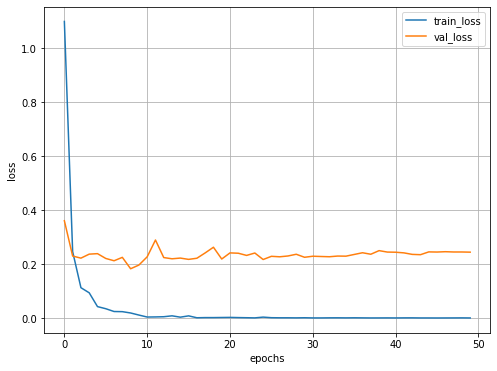

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.show()

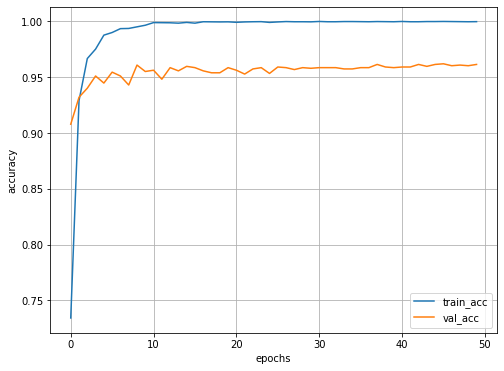

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.show()

In [18]:
vgg19_ft = copy.deepcopy(vgg19.features[:11])
vgg19_ft

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [19]:
torch.save(vgg19_ft.state_dict(), Path(str(DATA_DIR) + str('/vgg19.pth'))) # Веса первых 11-ти слоев

In [29]:
# загрузка весов
vgg19_ft.load_state_dict(torch.load(Path(str(DATA_DIR) + str('/vgg19.pth')), map_location=torch.device('cuda')))
vgg19_ft.eval()